In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #000000; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);width:95%;">
    <h1 style="color: red; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">Import Required Libraries</h1>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

from imblearn.over_sampling import SMOTE
from collections import Counter

from warnings import filterwarnings
filterwarnings("ignore")

<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #000000; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);width:95%;">
    <h1 style="color: red; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">Load Dataset</h1>
</div>

In [2]:
train = pd.read_csv('synthetic_fraud_dataset.csv')

<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #000000; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);width:95%;">
    <h1 style="color: red; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">Dataset View</h1>
</div>

In [3]:
print("Train shape:", train.shape)

Train shape: (10000, 10)


In [4]:
train.head()

,transaction_id,user_id,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud
0,9608,363,4922.587542,ATM,Travel,TR,12,0.992347,0.947908,1
1,456,692,48.018303,QR,Food,US,21,0.168571,0.224057,0
2,4747,587,136.881960,Online,Travel,TR,14,0.296127,0.125058,0
3,6934,445,80.534719,POS,Clothing,TR,23,0.124801,0.159243,0
4,1646,729,120.041158,Online,Grocery,FR,16,0.098129,0.027542,0


In [5]:
train.tail()

,transaction_id,user_id,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud
9995,1076,482,58.366442,POS,Clothing,DE,12,0.066366,0.086344,0
9996,4995,904,139.502160,POS,Travel,DE,13,0.119014,0.285680,0
9997,3485,527,71.012122,Online,Travel,TR,8,0.119204,0.262262,0
9998,7922,771,21.031405,QR,Grocery,UK,12,0.027088,0.295243,0
9999,6451,429,54.028632,ATM,Electronics,DE,11,0.096438,0.042823,0


`check Missing Values`

In [6]:
print("="*30)
print("| 'Missing values in dataset':|")
print("="*30)
print(train.isnull().sum())

| 'Missing values in dataset':|
transaction_id       0
user_id              0
amount               0
transaction_type     0
merchant_category    0
country              0
hour                 0
device_risk_score    0
ip_risk_score        0
is_fraud             0
dtype: int64


`Check Duplicate`

In [7]:
train.duplicated().sum().sum()

np.int64(0)

<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #000000; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);width:95%;">
    <h1 style="color: red; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">Statistical Analysis</h1>
</div>

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     10000 non-null  int64  
 1   user_id            10000 non-null  int64  
 2   amount             10000 non-null  float64
 3   transaction_type   10000 non-null  object 
 4   merchant_category  10000 non-null  object 
 5   country            10000 non-null  object 
 6   hour               10000 non-null  int64  
 7   device_risk_score  10000 non-null  float64
 8   ip_risk_score      10000 non-null  float64
 9   is_fraud           10000 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction_id,10000.0,4999.500000,2886.895680,0.000000,2499.750000,4999.500000,7499.250000,9999.000000
user_id,10000.0,500.058700,288.328495,0.000000,247.000000,503.000000,750.250000,999.000000
amount,10000.0,178.142763,531.647950,1.000000,65.084753,101.686510,138.280872,11628.213881
hour,10000.0,14.247100,5.347383,0.000000,10.000000,14.000000,19.000000,23.000000
device_risk_score,10000.0,0.183773,0.177381,0.000030,0.075721,0.156583,0.234939,0.998737
ip_risk_score,10000.0,0.184669,0.175772,0.000009,0.077762,0.158290,0.236968,0.999603
is_fraud,10000.0,0.050000,0.217956,0.000000,0.000000,0.000000,0.000000,1.000000


<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #000000; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);width:95%;">
    <h1 style="color: red; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">Visualization</h1>
</div>

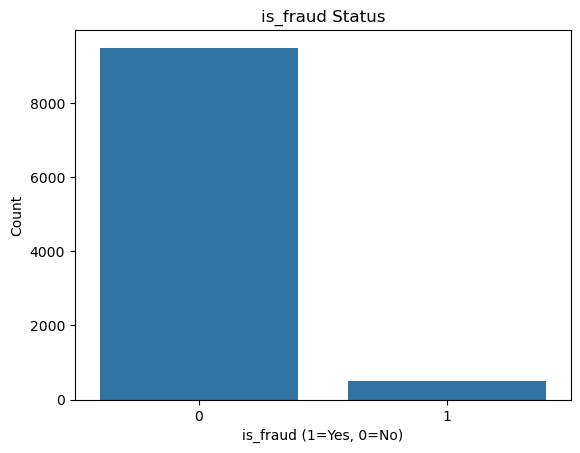

In [10]:
sns.countplot(x="is_fraud", data=train)
plt.title("is_fraud Status")
plt.xlabel("is_fraud (1=Yes, 0=No)")
plt.ylabel("Count")
plt.show()

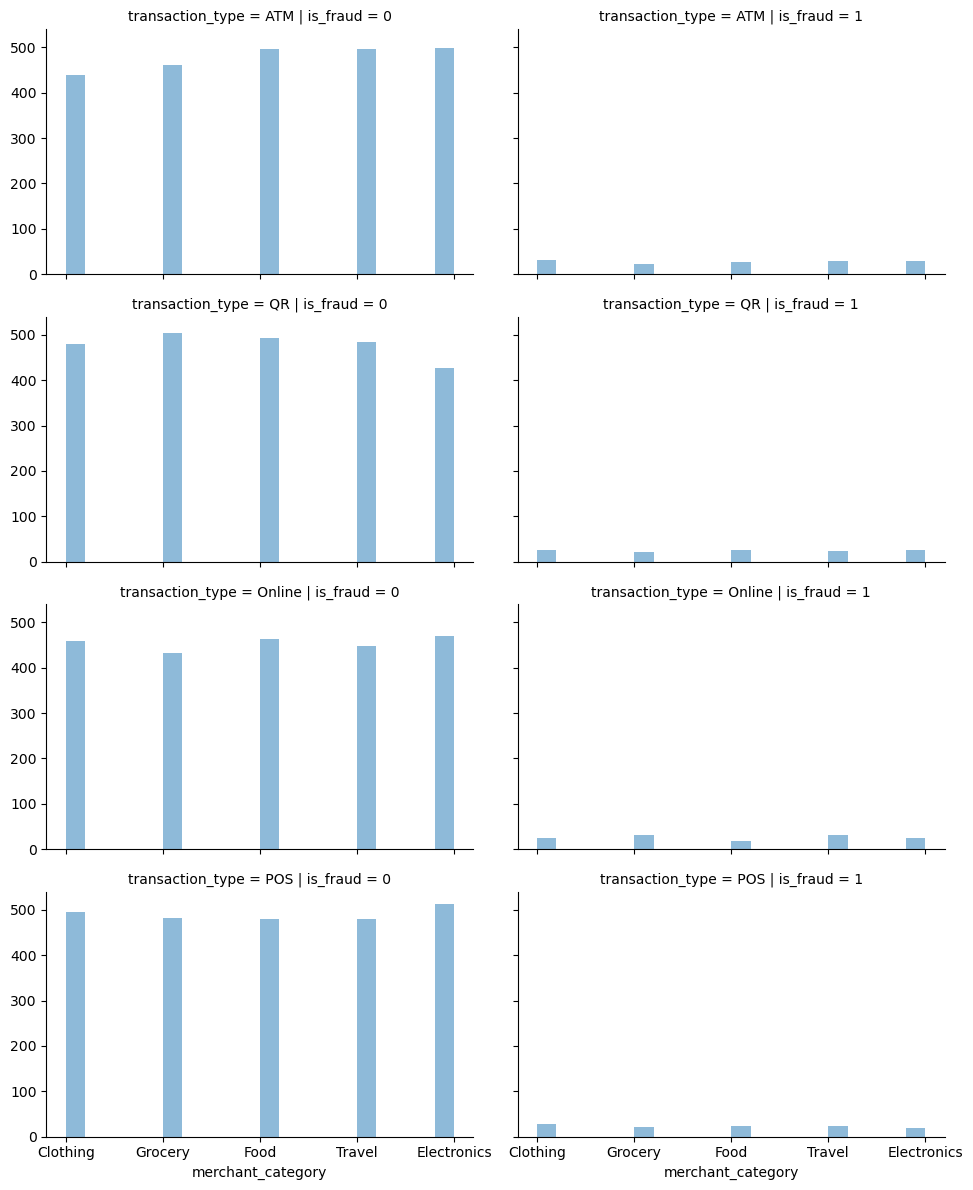

In [11]:
grid = sns.FacetGrid(train, col='is_fraud', row='transaction_type', aspect=1.6)
grid.map(plt.hist, 'merchant_category', alpha=.5, bins=20)
grid.add_legend()

<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #000000; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);width:95%;">
    <h1 style="color: red; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">Outlier Detection</h1>
</div>

In [12]:
columns=['transaction_type',
         'merchant_category', 
         'country', 'hour', 
         'device_risk_score',
         'ip_risk_score']

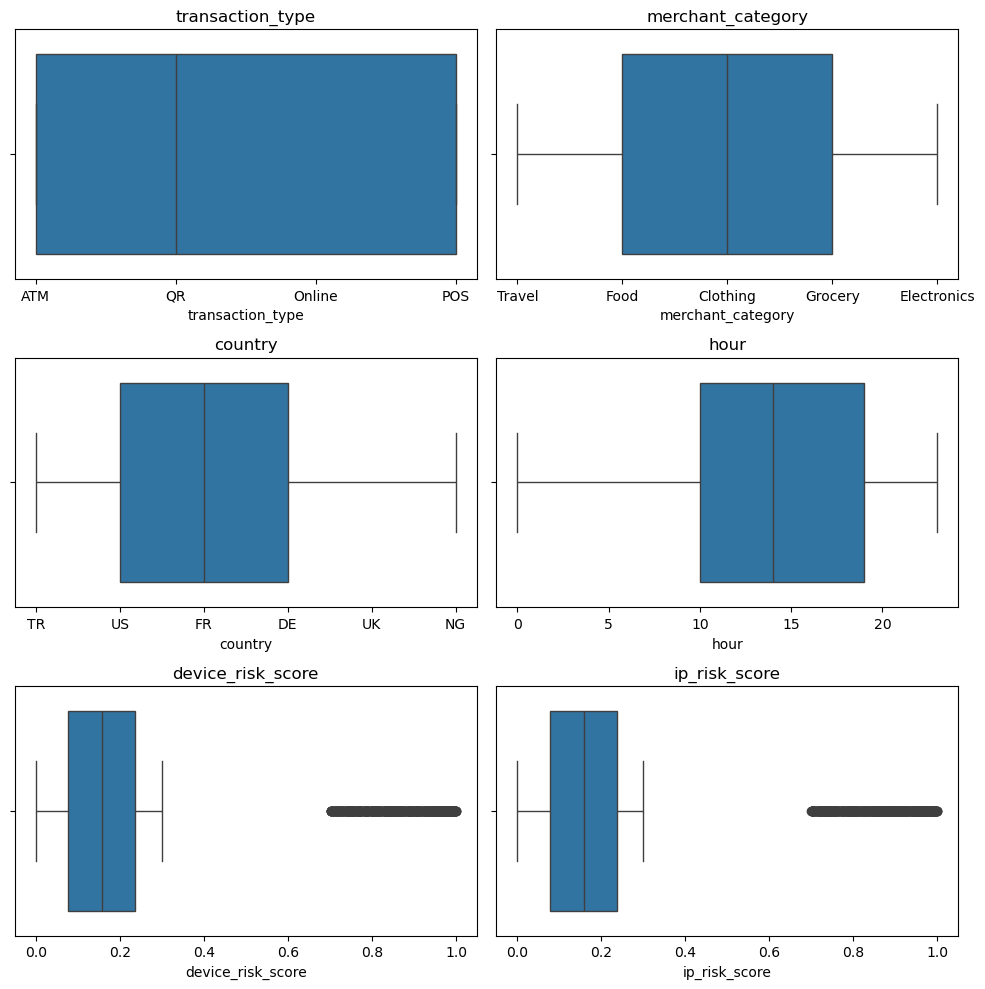

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for ax, col in zip(axes.flat, columns):
    sns.boxplot(x=col, data=train, ax=ax)
    ax.set_title(f"{col}")
plt.tight_layout()
plt.show()

<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #000000; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);width:95%;">
    <h1 style="color: red; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">Data Encoding</h1>
</div>

In [14]:
le = LabelEncoder()

# find object columns that exist in both train and test
obj_cols = train.select_dtypes(include='object').columns

for col in obj_cols:
    train[col]=le.fit_transform(train[[col]])

<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #000000; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);width:95%;">
    <h1 style="color: red; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">Feature Selection</h1>
</div>

In [25]:
x=train.drop("is_fraud",axis=1)
y=train["is_fraud"]

print(f"Original Class Distribution: {Counter(y)}")

Original Class Distribution: Counter({0: 9500, 1: 500})


<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #000000; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);width:95%;">
    <h1 style="color: red; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">Data Split</h1>
</div>

In [26]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #000000; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);width:95%;">
    <h1 style="color: red; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">Balance Classes</h1>
</div>

In [27]:
smote = SMOTE(random_state=42)

x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

# 5. Verify the results
print(f"Class Distribution after SMOTE: {Counter(y_train_balanced)}")

Class Distribution after SMOTE: Counter({0: 7600, 1: 7600})


<div style="border-radius: 30px 0 30px 0px; border: 2px solid #00ea98; padding: 20px; background-color: #000000; text-align: center; box-shadow: 0px 2px 4px rgba(0, 0, 0, 0.2);width:95%;">
    <h1 style="color: red; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); font-weight: bold; margin-bottom: 10px; font-size: 36px;">Data Modeling</h1>
</div>

# `Decision Tree`

In [29]:
model=DecisionTreeClassifier(random_state=42)
model.fit(x_train_balanced,y_train_balanced)
# model.fit(x_train,y_train)
y_pred1=model.predict(x_test)

print("accuracy_score: ",accuracy_score(y_test,y_pred1))
print("f1_score",f1_score(y_test,y_pred1))
print("confusion_matrix: \n",confusion_matrix(y_test,y_pred1))

accuracy_score:  1.0
f1_score 1.0
confusion_matrix: 
 [[1900    0]
 [   0  100]]


# `Random Forest`

In [30]:
rf=RandomForestClassifier(random_state=42,n_estimators=10,n_jobs=-2)
rf.fit(x_train_balanced,y_train_balanced)
# rf.fit(x_train,y_train)
y_pred2=rf.predict(x_test)

print("accuracy_score: ",accuracy_score(y_test,y_pred2))
print("f1_score",f1_score(y_test,y_pred2))
print("confusion_matrix:\n ",confusion_matrix(y_test,y_pred2))

accuracy_score:  1.0
f1_score 1.0
confusion_matrix:
  [[1900    0]
 [   0  100]]


# `XGBRegressor`

In [31]:
xgb = XGBClassifier(
	n_jobs=-2,
	random_state=42,
	n_estimators=100
)
xgb.fit(x_train_balanced,y_train_balanced)
y_pred3 = xgb.predict(x_test)

print("accuracy_score: ", accuracy_score(y_test, y_pred3))
print("f1_score", f1_score(y_test, y_pred3))
print("confusion_matrix: \n", confusion_matrix(y_test, y_pred3))

accuracy_score:  1.0
f1_score 1.0
confusion_matrix: 
 [[1900    0]
 [   0  100]]


# Logistic Regression

In [39]:
lr = LogisticRegression(max_iter=100)

lr.fit(x_train_balanced, y_train_balanced)
y_pred4 = lr.predict(x_test)

print("accuracy_score: ", accuracy_score(y_test, y_pred4))
print("confusion_matrix: \n", confusion_matrix(y_test, y_pred4))

accuracy_score:  0.943
confusion_matrix: 
 [[1795  105]
 [   9   91]]


In [36]:
print("✅ Script executed successfully.")
print("\nThanks!")

✅ Script executed successfully.

Thanks!
